In [6]:
from dotenv import load_dotenv
load_dotenv() # OPENAI_API_KEY, PINECONE_API_KEY

True

In [7]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

llm = ChatOpenAI(model="gpt-4.1", temperature=0)
small_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = PineconeVectorStore(
    index_name="inhouse-python-index",
    embedding=embeddings,
)
retriever = vector_store.as_retriever()

In [5]:
llm.invoke("인프런에는 어떤 강의가 있나요?")

AIMessage(content='인프런(Inflearn)은 다양한 분야의 온라인 강의를 제공하는 한국의 대표적인 교육 플랫폼입니다. 인프런에서 제공하는 강의는 주로 다음과 같은 분야로 나눌 수 있습니다:\n\n### 1. 개발/프로그래밍\n- 웹 개발 (HTML, CSS, JavaScript, React, Vue, Angular 등)\n- 백엔드 개발 (Node.js, Django, Spring, Flask, Java, Python 등)\n- 모바일 앱 개발 (Android, iOS, Flutter, React Native 등)\n- 데이터베이스 (MySQL, MongoDB, Oracle 등)\n- 알고리즘/자료구조\n- 인공지능/머신러닝/딥러닝 (TensorFlow, PyTorch 등)\n\n### 2. 데이터 사이언스\n- 데이터 분석 (Pandas, Numpy, Excel 등)\n- 통계/수학\n- 빅데이터 (Hadoop, Spark 등)\n- 데이터 시각화 (Tableau, Power BI 등)\n\n### 3. IT/소프트웨어\n- 클라우드 (AWS, Azure, GCP 등)\n- DevOps (Docker, Kubernetes, CI/CD 등)\n- 보안/네트워크\n\n### 4. 디자인/영상\n- UX/UI 디자인\n- 포토샵, 일러스트레이터, Figma 등 디자인 툴\n- 영상 편집 (Premiere, After Effects 등)\n\n### 5. 비즈니스/마케팅\n- 디지털 마케팅 (SEO, 구글 애드워즈, SNS 마케팅 등)\n- 창업/스타트업\n- 엑셀/파워포인트/오피스 활용\n\n### 6. 기타\n- 자격증 (정보처리기사, 컴퓨터활용능력 등)\n- 외국어 (영어, 일본어, 중국어 등)\n- 자기계발, 생산성, 커뮤니케이션\n\n---\n\n**인프런 홈페이지**에서 카테고리별로 강의를 쉽게 찾아볼 수 있으며, 인기 강의, 신규 강의, 무료 강의 등도 확인할 수 있습니다.  \n더 궁금한 특정 분야나 강의가 있다면 말씀해 주세요!', 

In [9]:
small_llm.invoke("인프런에는 어떤 강의가 있나요?")

AIMessage(content='인프런(Inflearn)은 다양한 분야의 온라인 강의를 제공하는 플랫폼으로, 주로 IT, 프로그래밍, 데이터 사이언스, 디자인, 마케팅 등 여러 주제의 강의를 찾을 수 있습니다. 대표적인 강의 카테고리는 다음과 같습니다:\n\n1. **프로그래밍**  \n   - Python, Java, JavaScript, C++, C# 등 다양한 프로그래밍 언어 강의  \n   - 웹 개발 (React, Vue, Angular, Node.js 등)  \n   - 모바일 앱 개발 (Android, iOS, Flutter 등)  \n   - 백엔드 개발 (Spring, Django, Express 등)\n\n2. **데이터 사이언스 & 인공지능**  \n   - 데이터 분석, 머신러닝, 딥러닝  \n   - TensorFlow, PyTorch, Scikit-learn 등 라이브러리 활용법  \n   - 자연어 처리, 컴퓨터 비전\n\n3. **클라우드 & DevOps**  \n   - AWS, Azure, Google Cloud 강의  \n   - Docker, Kubernetes, CI/CD 파이프라인 구축\n\n4. **디자인 & UX/UI**  \n   - 그래픽 디자인, UI/UX 디자인  \n   - Figma, Adobe XD, Photoshop, Illustrator 활용법\n\n5. **마케팅 & 비즈니스**  \n   - 디지털 마케팅, SEO, 콘텐츠 마케팅  \n   - 스타트업, 창업, 기획 관련 강의\n\n6. **기타**  \n   - 자격증 준비 강의 (정보처리기사, SQLD 등)  \n   - 취업 준비, 면접 대비 강의\n\n인프런에서는 초보자부터 전문가까지 다양한 수준의 강의를 제공하며, 실습 중심의 강의가 많아 실무에 바로 적용할 수 있는 내용이 많습니다. 관심 있는 분야를 검색하거나 추천 강의를 확인해 보시면 좋습니다.', additional_kwargs={'refusal': None}, response_m

In [25]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langchain_core.documents import Document


class AgentState(TypedDict):
    question: str
    answer: str
    context: list[Document]
    document_name: str
    is_in_faq: bool
    
graph_builder = StateGraph(AgentState)

In [10]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.output_parsers import StrOutputParser


def check_faq(state: AgentState) -> AgentState:
    question = state['question']
    context = retriever.invoke(question, filter={"source": "employee_benefits_and_welfare_faq"})
    check_faq_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that checks if the question is in the FAQ. 
If the question is in the FAQ, return 'Yes'. Otherwise, return 'No'."""),
        ("user", "Question: {question}\nContext: {context}"),
    ])
    check_faq_chain = check_faq_prompt | llm | StrOutputParser()
    is_in_faq = check_faq_chain.invoke({"question": question, "context": context})
    return {"is_in_faq": is_in_faq == "Yes", "context": context if is_in_faq == "Yes" else []}

In [13]:
check_faq({"question":"본인 결혼식 경조휴가는 얼마인가요?"})

{'is_in_faq': True,
 'context': [Document(id='2d154525-7dfd-4519-a991-f37cdbf520fa', metadata={'chapter': '3. 경조 휴가 및 지원', 'section': 'Q6: 경조 휴가는 어떤 경우에 사용할 수 있나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- **A:** 본인 결혼, 자녀 출생, 부모/배우자 사망 등 경조사 사유에 따라 휴가가 부여됩니다.'),
  Document(id='209330b3-b13a-42a2-a216-07b7b8035058', metadata={'source': 'employee_benefits_and_welfare_faq', 'title': '7. 문의 및 기타'}, page_content='**Q14: 복리후생 관련 문의는 어디로 하면 되나요?**\n- A: HR 담당자 김지현 (이메일: kimjh@company.com, 전화번호: 02-1234-5678)에게 문의 가능합니다.'),
  Document(id='7b06b5ec-ae07-4baf-a8d2-14c1390dcc1c', metadata={'chapter': '1. 연차 유급 휴가 관련', 'section': 'Q1: 연차 휴가는 어떻게 사용하나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- **A:** 연차 휴가는 본인 승인을 통해 자유롭게 사용할 수 있으며, 사내 HR 시스템에서 신청 가능합니다.'),
  Document(id='f888c9e4-f0d8-4684-ad80-12b3a6081faf', metadata={'chapter': '2. 출산 및 육아 휴가 관련', 'section': 'Q4: 출산 휴가는 언제부터 사용할 수 있나요?', '

In [14]:
def get_document_name(state: AgentState) -> AgentState:
    determine_document_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are a helpful assistant that determines the most relevant document name based on the user's question. 
Choose from the following document names:
- delegation_of_authority
- employee_benefits_and_welfare_faq
- employee_benefits_and_welfare_guide
- employee_handbook_and_hr_policy
- expense_management_guide
- it_support_guide
- legal_and_compliance_policy

Return ONLY the document name (e.g., 'it_support_guide').

Examples:
- If the question is about who can approve expenses, return 'delegation_of_authority' or 'expense_management_guide' as appropriate.
- If the question is about employee benefits, return 'employee_benefits_and_welfare_guide'.
- If the question is about HR policies or the employee handbook, return 'employee_handbook_and_hr_policy'.
- If the question is about IT support or technical issues, return 'it_support_guide'.
- If the question is about legal or compliance matters, return 'legal_and_compliance_policy'.
- If the question is a frequently asked question about benefits, return 'employee_benefits_and_welfare_faq'.
"""),
        ("user", "Question: {question}"),
    ]
)
    question = state['question']
    determine_document_chain = determine_document_prompt | small_llm | StrOutputParser()
    document_name = determine_document_chain.invoke({"question": question})
    return {"document_name": document_name}

In [15]:
get_document_name({"question":"본인 결혼식 경조휴가는 얼마인가요?"})

{'document_name': 'employee_benefits_and_welfare_guide'}

In [16]:
get_document_name({"question":"네트워크 담당자는 누구인가요?"})

{'document_name': 'it_support_guide'}

In [17]:
def retrieve_document(state: AgentState) -> AgentState:
    question = state['question']
    document_name = state['document_name']
    context = retriever.invoke(question, filter={"source": document_name})
    return {"context": context}

In [19]:
retrieve_document({"question": "네트워크 담당자는 누구인가요?", "document_name": "it_support_guide"})

{'context': [Document(id='cc454098-bd6e-4c6d-8107-5e3a7d06533b', metadata={'chapter': '제 1 장 IT 지원 기본 정책', 'section': '제 3 조 (IT 지원 담당자)', 'source': 'it_support_guide', 'title': 'IT 지원 가이드'}, page_content='- **네트워크 지원**\n- 담당자: 김영수 (IT 네트워크 관리자)\n- 이메일: kimys@company.com\n- 전화번호: 02-1234-5680\n- **계정관리 및 보안**\n- 담당자: 이민정 (보안 관리자)\n- 이메일: leemj@company.com\n- 전화번호: 02-1234-5681\n- **소프트웨어 및 시스템 유지보수**\n- 담당자: 박성호 (IT 시스템 관리자)\n- 이메일: parksh@company.com\n- 전화번호: 02-1234-5682  \n---'),
  Document(id='2c156434-96bb-462f-85f4-f957f3b4a4d4', metadata={'chapter': '제 3장 네트워크 및 VPN 접속', 'section': '제 6조 (사내 네트워크 접속)', 'source': 'it_support_guide', 'title': 'IT 지원 가이드'}, page_content='- 모든 사내 네트워크 접속은 인증된 사용자 계정으로만 가능하다.\n- 외부 접속 시 VPN 사용이 필수이다.\n- VPN 계정은 IT 지원팀을 통해 신청할 수 있다.'),
  Document(id='38ffda2d-99f5-4408-9341-d5caaec1e436', metadata={'chapter': '제 3장 네트워크 및 VPN 접속', 'section': '제 7조 (VPN 접속 오류 해결)', 'source': 'it_support_guide', 'title': 'IT 지원 가이드'}, page_content='- VPN 접속 불가 시 네트워크 상태

In [21]:
def generate_answer(state: AgentState) -> AgentState:
    question = state['question']
    context = state['context']
    generate_answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates an answer to the user's question based on the context.
        """),
        ("user", "Question: {question}\nContext: {context}"),
    ])
    generate_answer_chain = generate_answer_prompt | llm | StrOutputParser()
    answer = generate_answer_chain.invoke({"question": question, "context": context})
    return {"answer": answer}

In [23]:
from typing import Literal

def check_if_in_faq(state: AgentState) -> Literal["generate_answer", "get_document_name"]:
    is_in_faq = state['is_in_faq']
    if is_in_faq:
        return "generate_answer"
    else:
        return "get_document_name"

In [26]:
from langgraph.graph import START, END

graph_builder.add_node(check_faq)
graph_builder.add_node(get_document_name)
graph_builder.add_node(retrieve_document)
graph_builder.add_node(generate_answer)

graph_builder.add_edge(START, "check_faq")
graph_builder.add_conditional_edges("check_faq", check_if_in_faq)
graph_builder.add_edge("get_document_name", "retrieve_document")
graph_builder.add_edge("retrieve_document", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()

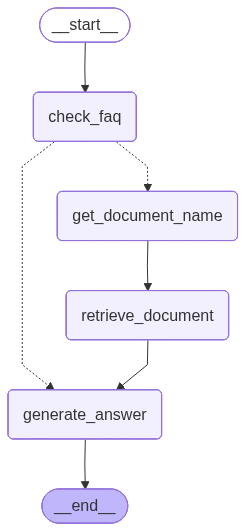

In [27]:
graph

In [28]:
graph.invoke({"question": "사내 네트워크 담당자는 누구인가요?"})

{'question': '사내 네트워크 담당자는 누구인가요?',
 'answer': '사내 네트워크 담당자는 김영수 (IT 네트워크 관리자)입니다.  \n- 이메일: kimys@company.com  \n- 전화번호: 02-1234-5680',
 'context': [Document(id='cc454098-bd6e-4c6d-8107-5e3a7d06533b', metadata={'chapter': '제 1 장 IT 지원 기본 정책', 'section': '제 3 조 (IT 지원 담당자)', 'source': 'it_support_guide', 'title': 'IT 지원 가이드'}, page_content='- **네트워크 지원**\n- 담당자: 김영수 (IT 네트워크 관리자)\n- 이메일: kimys@company.com\n- 전화번호: 02-1234-5680\n- **계정관리 및 보안**\n- 담당자: 이민정 (보안 관리자)\n- 이메일: leemj@company.com\n- 전화번호: 02-1234-5681\n- **소프트웨어 및 시스템 유지보수**\n- 담당자: 박성호 (IT 시스템 관리자)\n- 이메일: parksh@company.com\n- 전화번호: 02-1234-5682  \n---'),
  Document(id='2c156434-96bb-462f-85f4-f957f3b4a4d4', metadata={'chapter': '제 3장 네트워크 및 VPN 접속', 'section': '제 6조 (사내 네트워크 접속)', 'source': 'it_support_guide', 'title': 'IT 지원 가이드'}, page_content='- 모든 사내 네트워크 접속은 인증된 사용자 계정으로만 가능하다.\n- 외부 접속 시 VPN 사용이 필수이다.\n- VPN 계정은 IT 지원팀을 통해 신청할 수 있다.'),
  Document(id='2d344585-9434-4b9c-ad83-498511c2ee93', metadata={'chapter': '제 12조 

In [34]:
graph.invoke({"question": "출산 휴가는 얼마나 보장되나요?"}) # is_in_faq: True
# graph.invoke({"question": "출산휴가는 얼마나 보장되나요?"}) # is_in_faq: False

{'question': '출산 휴가는 얼마나 보장되나요?',
 'answer': '출산 휴가는 출산 예정일 전후로 자유롭게 사용할 수 있으며, 최대 20일 유급으로 보장됩니다.',
 'context': [Document(id='f888c9e4-f0d8-4684-ad80-12b3a6081faf', metadata={'chapter': '2. 출산 및 육아 휴가 관련', 'section': 'Q4: 출산 휴가는 언제부터 사용할 수 있나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- **A:** 출산 예정일 전후로 자유롭게 사용할 수 있으며, 최대 20일 유급으로 제공됩니다.'),
  Document(id='2d154525-7dfd-4519-a991-f37cdbf520fa', metadata={'chapter': '3. 경조 휴가 및 지원', 'section': 'Q6: 경조 휴가는 어떤 경우에 사용할 수 있나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- **A:** 본인 결혼, 자녀 출생, 부모/배우자 사망 등 경조사 사유에 따라 휴가가 부여됩니다.'),
  Document(id='fee14ed1-c751-4cbe-b757-5990df17b499', metadata={'chapter': '2. 출산 및 육아 휴가 관련', 'section': 'Q5: 육아 휴가는 누구에게 적용되나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- **A:** 모든 직원이 신청할 수 있으며, 최대 1년까지 사용할 수 있으며, 첫 3개월은 급여의 50%가 지급됩니다.  \n---'),
  Document(id='